# dis-cover debian packages analysis

I ran a script on a 16-core machine during the weekend to analyze all debian packages that have **libgcc1** as a dependency.

Almost 24h of computation later, here is a first analysis of the results !

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import requests

In [2]:
data = pickle.load(open("analysis.pickle", "rb"))

In [3]:
total_classes = 0
packages_where_class = 0
classes_in_packages = []
distribution = {}

In [4]:
print("The total number of packages that have libgcc1 as a dependency is %d." % len(data))

The total number of packages that have libgcc1 as a dependency is 5827.


In [5]:
for package in data:
    files = data[package]
    classes = 0
    for file in files:
        if file == "failed":
            continue
        classes += len(file)
        total_classes += len(file)
    classes_in_packages.append((package, classes))

    if distribution.get(classes) == None:
        distribution[classes] = 1
    else:
        distribution[classes] += 1

    if classes > 0:
        packages_where_class += 1

In [6]:
print("The number of packages where we were able to extract classes is %d out of %d (%d%%)." % (
    packages_where_class,
    len(data),
    packages_where_class / (len(data) or 1) * 100,
))
print("This means that those packages do not use the -fno-rtti flag and use virtual methods in their code.")
print("The total number of classes found is %d." % total_classes)
print(
    "The mean number of classes in packages where there are classes is %d." % (total_classes / (packages_where_class or 1)),
)

The number of packages where we were able to extract classes is 5127 out of 5827 (87%).
This means that those packages do not use the -fno-rtti flag and use virtual methods in their code.
The total number of classes found is 2062232.
The mean number of classes in packages where there are classes is 402.


In [7]:
classes_in_packages.sort(key=lambda p: p[1], reverse=True)
n = 20
print("Top %d packages by number of classes:" % n)
for (p, c) in classes_in_packages[:n]:
    print(" - %s has %d classes" % (p ,c))

Top 20 packages by number of classes:
 - piglit has 128003 classes
 - libwine-development has 71455 classes
 - libvtk7.1 has 52660 classes
 - libwine has 51007 classes
 - libvtk6.3 has 50416 classes
 - sagemath has 44607 classes
 - paraview has 30248 classes
 - vlc-plugin-base has 29768 classes
 - grass-core has 22130 classes
 - eso-midas has 21816 classes
 - libmia-2.4-4 has 20238 classes
 - libglib2.0-tests has 17358 classes
 - gnucash has 15972 classes
 - scalapack-mpi-test has 15344 classes
 - libc6 has 12082 classes
 - krita has 12020 classes
 - libopenmpi3 has 11988 classes
 - libmagickcore-6.q16hdri-6 has 11932 classes
 - libwildmagic-examples has 11124 classes
 - libmagickcore-6.q16-6 has 10972 classes


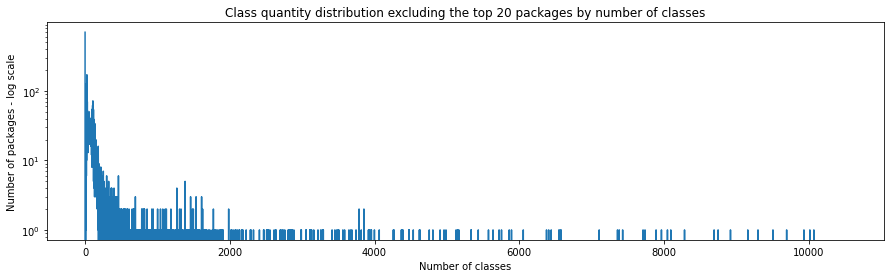

In [8]:
x = range(classes_in_packages[20][1])
y = [distribution.get(v) or 0 for v in x]
plt.figure(figsize=(15,4))
plt.plot(x, y)
plt.yscale('log')
plt.title("Class quantity distribution excluding the top 20 packages by number of classes")
plt.xlabel("Number of classes")
plt.ylabel("Number of packages - log scale")
plt.show()

In [9]:
print("20 classes from a random package\n")
print("\n".join([str(c) for c in data["ardour"]["ardour/usr/lib/ardour5/ardour-5.12.0"]][0:20]))

20 classes from a random package

class	boost::bad_weak_ptr
class	Gtk::ComboBoxText::TextModelColumns
class	InstrumentSelector::InstrumentListColumns
class	AddRouteDialog::TrackTemplateColumns
class	boost::exception
class	boost::exception_detail::error_info_injector<boost::bad_weak_ptr>	inherits from boost::exception, boost::bad_weak_ptr
class	boost::exception_detail::clone_base
class	boost::exception_detail::clone_impl<boost::exception_detail::error_info_injector<boost::bad_weak_ptr>>	inherits from boost::exception_detail::clone_base, boost::exception_detail::error_info_injector<boost::bad_weak_ptr>
class	AnalysisWindow::TrackListColumns
class	PBD::SignalBase
class	PBD::Signal0<void, PBD::OptionalLastValue<void>>	inherits from PBD::SignalBase
class	failed_constructor
class	PBD::Signal2<void, unsigned long, unsigned long, PBD::OptionalLastValue<void>>	inherits from PBD::SignalBase
class	PBD::Destructible
class	PBD::Signal2<void, bool, PBD::Controllable::GroupControlDisposition, PBD::Op

## By popularity

We now use data from [popcon](https://popcon.debian.org), the official debian popularity contest, in order to sort and isolate packages by **installation** and **usage**.

In [10]:
res = requests.get("https://popcon.debian.org/by_inst")
popularity = res.text

In [11]:
classes_dict = dict(classes_in_packages)

In [12]:
packages_with_votes = []
for line in popularity.split("\n")[:-3]:
    if line[0] == "#":
        continue
    (name, inst, vote) = line.split()[1:4]
    classes = classes_dict.get(name)
    if classes != None:
        packages_with_votes.append((name, int(inst), int(vote), classes))

In [13]:
by_inst = sorted(packages_with_votes, key=lambda x: x[1], reverse=True)
by_vote = sorted(packages_with_votes, key=lambda x: x[2], reverse=True)

def print_stats(sorted_list, n):
    mean = 0
    no_classes = 0
    filtered_list = sorted_list[:n]
    for v in filtered_list:
        mean += v[-1]
        if v[-1] == 0:
            no_classes += 1
    mean /= n
    print("There are %d packages with no classes (either -fno-rtti or no virtual methods)." % no_classes)
    print("There is a mean of %d classes per package" % mean)

n = 100
print("In the top %d C++ packages, sorted by installations:" % n)
print_stats(by_inst, n)
print()
print("In the top %d C++ packages, sorted by usage:" % n)
print_stats(by_vote, n)

n = 1000
print()
print("In the top %d C++ packages, sorted by installations:" % n)
print_stats(by_inst, n)
print()
print("In the top %d C++ packages, sorted by usage:" % n)
print_stats(by_vote, n)

In the top 100 C++ packages, sorted by installations:
There are 10 packages with no classes (either -fno-rtti or no virtual methods).
There is a mean of 443 classes per package

In the top 100 C++ packages, sorted by usage:
There are 15 packages with no classes (either -fno-rtti or no virtual methods).
There is a mean of 865 classes per package

In the top 1000 C++ packages, sorted by installations:
There are 87 packages with no classes (either -fno-rtti or no virtual methods).
There is a mean of 654 classes per package

In the top 1000 C++ packages, sorted by usage:
There are 74 packages with no classes (either -fno-rtti or no virtual methods).
There is a mean of 680 classes per package


## Conclusion

Overall, this analysis is very positive for the project : Around **92%** of **regularly used and installed C++ packages** have RTTI info we can extract, and the quantity of classes we can recover is quite substantial !